<a href="https://colab.research.google.com/github/Pager07/FinalYearProject/blob/master/ActionRecognitionClassifier2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Ladder Board

- Downloading the data 
-Importing 
  - Fastai
  - Google drive
- Understanding the data 
  - Loading the data
    - setting up variables
      - root_dir (Path to main project folder) 
      - base_dir (Path to data folder)
    - Loading Images 
      - Looking at images in drive and cleaning up data 
- Creating DataObject
  - Loading action labels
  - ItemList
    - spliting it into train and val
- Creating Databunch
  - Look at batches 
    - Clean up the data in Drive

- Creating the learner
  - Finding best LR 

- Fitting the model in smaller(images)
  - Fit frozen layers
  - Unfreez and fit 

- Fitting the mode in larger images 

#Importing FastAi Library

In [0]:
%reload_ext autoreload 
%autoreload 2
%matplotlib inline
from fastai.vision import *

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [0]:
from google.colab import drive

In [8]:
drive.mount('/content/gdrive' , force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install wandb

In [0]:
import wandb
wandb.init(project="action-classification")
from wandb.fastai import WandbCallback

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


W&B Run: https://app.wandb.ai/pager07/action-classification/runs/104ypeua

#Understanding the data

In [0]:
root_dir = '/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data6'
base_dir = root_dir + '/trainMerged'
path = Path(base_dir)

In [0]:
img = open_image(path/'train'/'3-Pointer'/'3-Pointer1.mov.png')


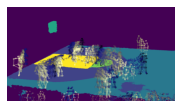

In [11]:
img.show()

#Fuction to set random seed

In [0]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

#Creating DataObject,DataLoader and Databunch

In [0]:
#We are only fliping the image in the y-axis. I may play around with maz_zoon and wrap later to see how it affects the results
transforms = get_transforms()

In [0]:
#When this function is called, it gets passsed the filePath(PATH OBJECT) of the image
#Example: PosixPath('/content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data2/train/2_other 2-pointer failure.png')
def get_label(filePath):
  '''RETURNS LABELS'''
  label = str(filePath).split('/')[-1].split('.')[0].split('_')[-1]
  return label

In [0]:
'''TEST'''
a = path/'train'/'3-pointer failure'/'17_209,68_3-pointer failure.png'
str(a).split('/')[-1].split('.')[0].split('_')[-1]

'3-pointer failure'

In [0]:
'''TEST'''
b = path/'train'/'24_3-pointer success.png'
str(b).split('/')[-1].split('.')[0].split('_')[1]

'3-pointer success'

In [0]:
#Creating Databunch. 
#np.random.seed(42)
random_seed(42,True)
data = ImageDataBunch.from_folder(path, train="train", valid_pct=0.3,
                                  ds_tfms = transforms, size =244,
                                  num_workers = 1,bs=64).normalize(imagenet_stats);

In [23]:
data.c , data.classes , len(data.train_ds) , len(data.valid_ds) , len(data.train_dl) , len(data.valid_dl)

(3, ['3-Pointer', 'Dunk', 'Free-throw'], 133, 56, 2, 1)

In [24]:
data.classes

['3-Pointer', 'Dunk', 'Free-throw']

In [25]:
data

ImageDataBunch;

Train: LabelList (133 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
Free-throw,Free-throw,Free-throw,Free-throw,Free-throw
Path: /content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data6/trainMerged;

Valid: LabelList (56 items)
x: ImageList
Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244),Image (3, 244, 244)
y: CategoryList
3-Pointer,3-Pointer,Free-throw,Free-throw,Dunk
Path: /content/gdrive/My Drive/My Notes/3rd year/Individual Projects/Data6/trainMerged;

Test: None

# Training:resnet34

In [0]:
'''
Using mixup data agumentation
'''
learn = cnn_learner(data, 
                    models.resnet34, 
                    metrics= [error_rate,accuracy, Recall(),Precision()], 
                    callback_fns=partial(WandbCallback, input_type='images')).mixup().to_fp16()

In [30]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,accuracy,recall,precision,time
0,1.984101,1.899377,0.535714,0.464286,0.412698,0.333333,00:41
1,2.021857,1.329142,0.500000,0.500000,0.444444,0.340548,00:12
2,1.906792,0.970821,0.375000,0.625000,0.571429,0.648949,00:11
3,1.719316,0.991207,0.410714,0.589286,0.555556,0.758730,00:11
4,1.610043,1.282789,0.446429,0.553571,0.531746,0.722222,00:11
5,1.492743,1.450621,0.410714,0.589286,0.571429,0.741667,00:11
6,1.406765,1.463140,0.392857,0.607143,0.595238,0.733333,00:11
7,1.365604,1.367059,0.339286,0.660714,0.658730,0.764286,00:11
8,1.319288,1.224787,0.375000,0.625000,0.626984,0.698611,00:11
9,1.294200,1.150200,0.375000,0.625000,0.634921,0.697090,00:11


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with valid_loss value: 1.8993772268295288.
Better model found at epoch 1 with valid_loss value: 1.3291419744491577.
Better model found at epoch 2 with valid_loss value: 0.9708206057548523.
Better model found at epoch 19 with valid_loss value: 0.9639135003089905.
Loaded best saved model from /content/wandb/run-20200327_151929-104ypeua/bestmodel.pth


In [0]:
learn.save('stage1-resnet34-size244')

In [0]:
learn.lr_find()


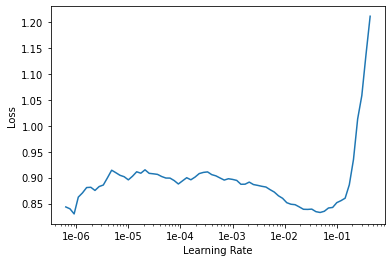

In [33]:
learn.recorder.plot()


In [34]:
learn.unfreeze()
learn.fit_one_cycle(30,max_lr=slice(1e-04,1e-01))


epoch,train_loss,valid_loss,error_rate,accuracy,recall,precision,time
0,3.020846,5.449212,0.678571,0.321429,0.396825,nan,00:11
1,2.643846,3.701163,0.553571,0.446429,0.507937,nan,00:11
2,2.324188,3.867890,0.571429,0.428571,0.492064,0.768116,00:11
3,1.974695,4.843967,0.428571,0.571429,0.507937,nan,00:11
4,1.765992,17.294930,0.607143,0.392857,0.357143,nan,00:11
5,1.635844,12.965055,0.750000,0.250000,0.333333,nan,00:11
6,1.578107,20.085537,0.535714,0.464286,0.444444,0.602564,00:11
7,1.512012,41.888393,0.517857,0.482143,0.444444,0.575758,00:11
8,1.510687,47.541080,0.464286,0.535714,0.547619,nan,00:11
9,1.517406,54.997486,0.392857,0.607143,0.539683,0.422161,00:11


Better model found at epoch 0 with valid_loss value: 5.449211597442627.


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Better model found at epoch 1 with valid_loss value: 3.701162815093994.
Better model found at epoch 18 with valid_loss value: 1.7694218158721924.
Better model found at epoch 29 with valid_loss value: 1.6930314302444458.
Loaded best saved model from /content/wandb/run-20200327_151929-104ypeua/bestmodel.pth


In [0]:
learn.save('stage2-resnet34-size244')

#Results

In [0]:
learn.load("stage2-resnet50-size128")
learn.data = data

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

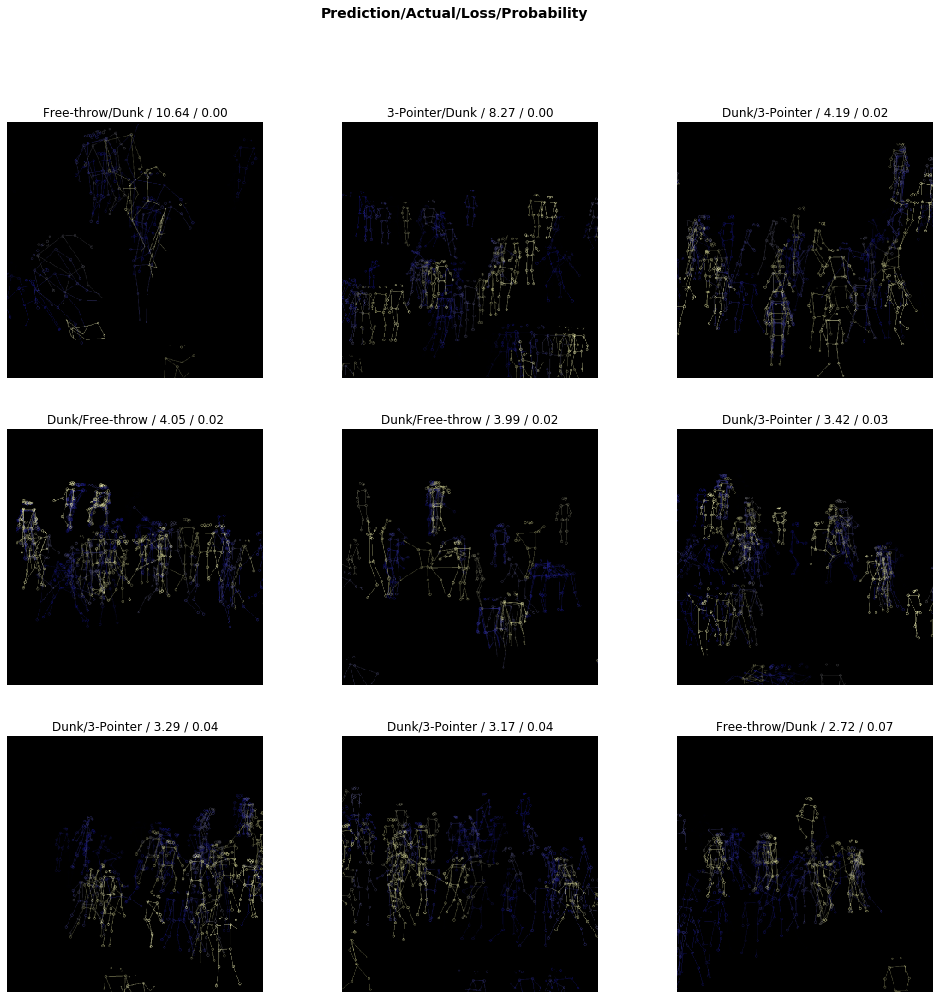

In [0]:
interp.plot_top_losses(9,figsize=(17,16))

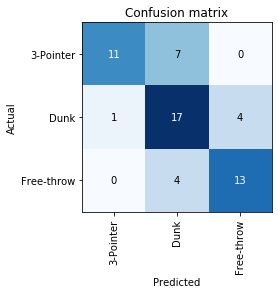

In [0]:
interp.plot_confusion_matrix()

In [0]:
interp.most_confused(min_val=2)

[('3-Pointer', 'Dunk', 7),
 ('Dunk', 'Free-throw', 4),
 ('Free-throw', 'Dunk', 4)]

#Retraining on bigger images

In [0]:
learn.freeze()
data = ImageDataBunch.from_folder(path, train="train", valid_pct=0.3,
                                  ds_tfms = transforms, size = 512,
                                  num_workers = 1,bs=64).normalize(imagenet_stats);
learn.data = data                              

In [38]:
learn.data.add_tfm(to_half)
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,accuracy,recall,precision,time
0,1.033038,1.119196,0.321429,0.678571,0.688142,0.675214,00:15
1,1.009359,0.723278,0.285714,0.714286,0.712418,0.707071,00:15
2,1.000976,0.562697,0.232143,0.767857,0.763772,0.762653,00:14
3,0.982216,0.487588,0.160714,0.839286,0.830999,0.852633,00:15
4,0.940194,0.445246,0.142857,0.857143,0.850607,0.866632,00:15
5,0.910456,0.430769,0.142857,0.857143,0.850607,0.866632,00:15
6,0.925046,0.424781,0.178571,0.821429,0.815126,0.827778,00:15
7,0.919170,0.415471,0.160714,0.839286,0.830999,0.856364,00:15
8,0.898661,0.399006,0.160714,0.839286,0.830999,0.856364,00:15
9,0.873291,0.385681,0.178571,0.821429,0.815126,0.827778,00:14


Better model found at epoch 0 with valid_loss value: 1.1191961765289307.


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Better model found at epoch 1 with valid_loss value: 0.7232776880264282.
Better model found at epoch 2 with valid_loss value: 0.5626968145370483.
Better model found at epoch 3 with valid_loss value: 0.48758816719055176.
Better model found at epoch 4 with valid_loss value: 0.44524604082107544.
Better model found at epoch 5 with valid_loss value: 0.43076857924461365.
Better model found at epoch 6 with valid_loss value: 0.4247812330722809.
Better model found at epoch 7 with valid_loss value: 0.4154708981513977.
Better model found at epoch 8 with valid_loss value: 0.3990055024623871.
Better model found at epoch 9 with valid_loss value: 0.3856808841228485.
Better model found at epoch 10 with valid_loss value: 0.3787021338939667.
Better model found at epoch 11 with valid_loss value: 0.3719864785671234.
Better model found at epoch 12 with valid_loss value: 0.36511561274528503.
Better model found at epoch 14 with valid_loss value: 0.3636375367641449.
Better model found at epoch 15 with valid_l

In [0]:
learn.save('stage3-resnet34-size512')

In [0]:
learn.unfreeze()
learn.lr_find()

In [0]:
learn.lr_find()

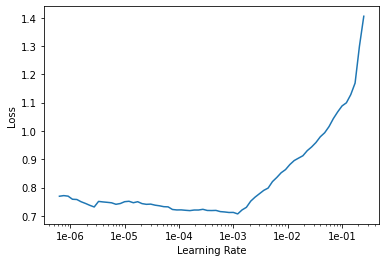

In [44]:
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(30,max_lr=slice(1e-05,1e-03))


epoch,train_loss,valid_loss,error_rate,accuracy,recall,precision,time
0,0.628039,0.450344,0.196429,0.803571,0.802521,0.810817,00:14
1,0.688261,0.390555,0.196429,0.803571,0.801432,0.806595,00:15
2,0.668950,0.380081,0.160714,0.839286,0.838469,0.835631,00:15
3,0.679283,0.369694,0.196429,0.803571,0.804077,0.802214,00:15
4,0.678064,0.358437,0.178571,0.821429,0.822596,0.816667,00:14
5,0.682610,0.356204,0.196429,0.803571,0.806723,0.798786,00:14
6,0.673885,0.400613,0.142857,0.857143,0.865546,0.862500,00:14
7,0.681918,0.387162,0.142857,0.857143,0.861811,0.858699,00:14
8,0.682386,0.334169,0.142857,0.857143,0.855431,0.854793,00:14
9,0.667525,0.330865,0.125000,0.875000,0.867569,0.883716,00:14


Better model found at epoch 0 with valid_loss value: 0.45034390687942505.


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Better model found at epoch 1 with valid_loss value: 0.39055532217025757.
Better model found at epoch 2 with valid_loss value: 0.380080908536911.
Better model found at epoch 3 with valid_loss value: 0.3696940839290619.
Better model found at epoch 4 with valid_loss value: 0.35843661427497864.
Better model found at epoch 5 with valid_loss value: 0.35620376467704773.
Better model found at epoch 8 with valid_loss value: 0.334168940782547.
Better model found at epoch 9 with valid_loss value: 0.3308652341365814.
Better model found at epoch 12 with valid_loss value: 0.3203602433204651.
Better model found at epoch 13 with valid_loss value: 0.30668967962265015.
Better model found at epoch 16 with valid_loss value: 0.3050292134284973.
Better model found at epoch 23 with valid_loss value: 0.3009676933288574.
Better model found at epoch 24 with valid_loss value: 0.29724040627479553.
Better model found at epoch 25 with valid_loss value: 0.29715290665626526.
Better model found at epoch 26 with valid

In [0]:
learn.load('/content/wandb/run-20200327_151929-104ypeua/bestmodel')

In [0]:
learn.export()

#Getting precision and recall for all classes

#Stage2 Results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

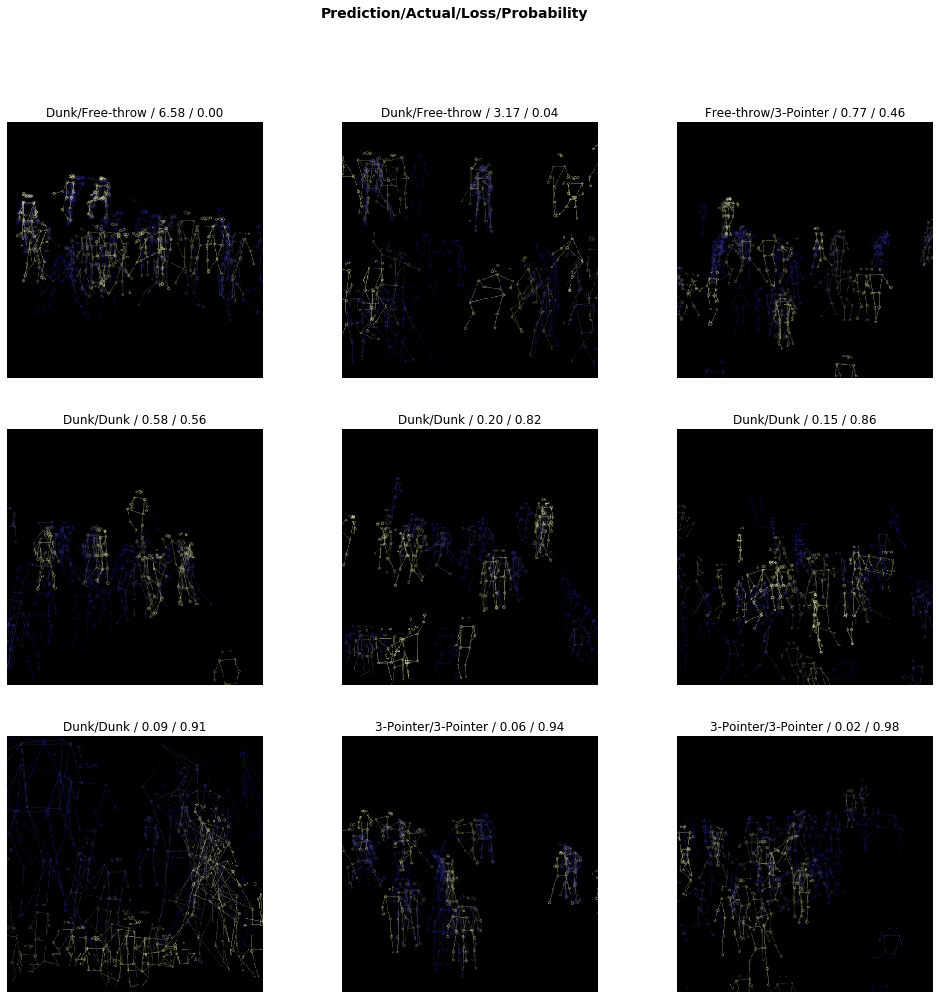

In [0]:
interp.plot_top_losses(9,figsize=(17,16))

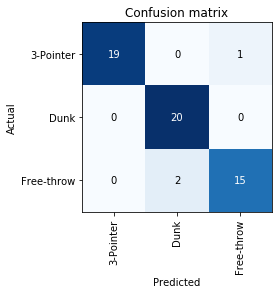

In [0]:
interp.plot_confusion_matrix()

In [0]:
interp.most_confused(min_val=2)

[('Free-throw', 'Dunk', 2)]

#Evaluation TIPS

Error Rate
  - Increase over epoch
  - 

Valid_loss
  - What does it mean, intutively?
  - How much is good?
  - Low-High-Low
  - TOO HIGHH!!
    - LR RATE IS TOO HIGH, LOWER IT!


Learning Rate == Small Epochs
  - TOO SMALL
    - error_rate is going down really slow
    - train_loss is bigger than valid_loss
        - Have not trained enough 
  - TOO BIG
    - Valid LOSSS HIGH!!!

OVERFIT
  - Training LOSS < Validation Loss NOT OVERFITTING!
  - Error starting incrasing!!


How do I know if I need more dataset?
- You cant change LR any more
    - Increasing it gives MASSIIVe VALID LOSSE
    - Decreasing it goes reallyyyy slowly
- You trained long enough 
  - And the accuracy is stil not good

